In [271]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.optimize import curve_fit


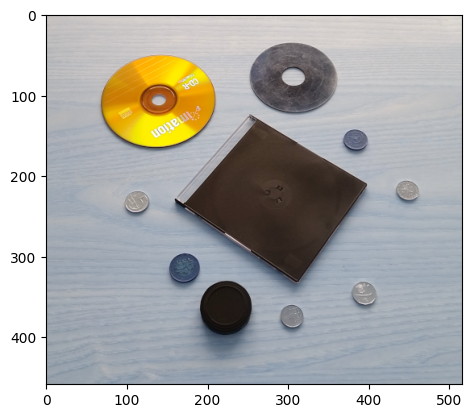

In [272]:
image=cv2.imread(".\Data\cd_box.png")
plt.imshow(image)

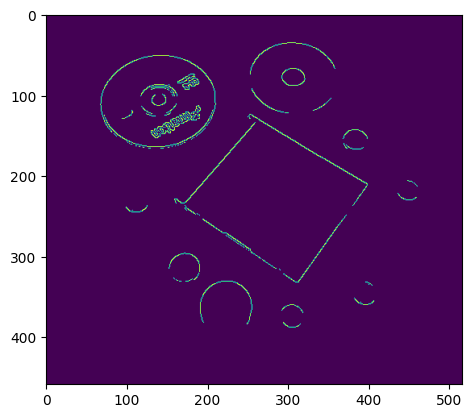

In [273]:
edges=cv2.Canny(image,350,400)
plt.imshow(edges)

In [274]:
edge_positions=cv2.findNonZero(edges)
edge_positions=np.reshape(edge_positions,(edge_positions.shape[0],edge_positions.shape[2]))
edge_positions.shape

(2968, 2)

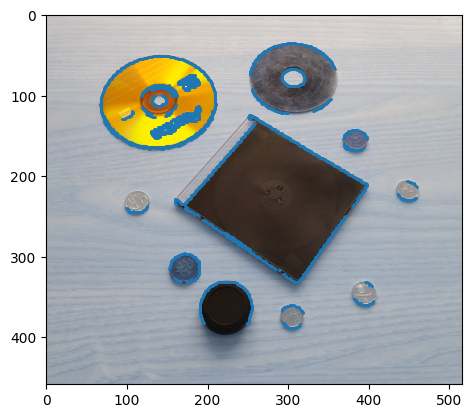

In [275]:
plt.imshow(image)
plt.plot(edge_positions[:,0],edge_positions[:,1],'o',markersize=1)

In [276]:
class LinearModel:
    def __init__(self,a:float=0,b:float=0):
        self.a=a
        self.b=b

    def fit(self,data:np.array):
        popt,pcov=curve_fit(lambda x,a,b:a*x+b,data[:,0],data[:,1])
        self.a=popt[0]
        self.b=popt[1]

    def loss(self,y_true:np.array):
        y_pred=self.a*y_true[:,0]+self.b
        return (y_true[:,1]-y_pred)**2
    
    def metric(self,y_true:np.array):
        return np.sum(self.loss(y_true))/y_true.shape[0]


In [277]:

def RANSAC(n:int,max_iter:int,eps:float,min_inliers:int):
    iterations=0
    model_error=10000
    final_inliers=np.array([])
    best_model=None
    model=LinearModel()
    while iterations<max_iter:
        indices=np.random.choice(edge_positions.shape[0],n,False)
        points_to_fit=edge_positions[indices]
        model.fit(points_to_fit)
        loss_per_datapoint=model.loss(edge_positions)
        inliers=edge_positions[loss_per_datapoint<eps]
        #print(inliers.shape)
        if inliers.shape[0]>min_inliers:
            inlier_model=LinearModel()
            inlier_model.fit(inliers)
            inlier_error=inlier_model.metric(inliers)
            if inlier_error<model_error:
                print("Better model found. Iteration: ",iterations, " Error: ", inlier_error," Num inliers: ", inliers.shape[0] )
                model_error=inlier_error
                final_inliers=inliers
                best_model=inlier_model
        iterations+=1
    if best_model==None:
        print("A good model was not found, try tuning the parameters")
        best_model=model
    return final_inliers,best_model

In [278]:

edge_positions_cpy=edge_positions.copy()
lines=[]
for i in range(4):
    print("Line ",i)
    print("=====================================")
    pixels_on_line,model=RANSAC(2,1000,2,100)
    lines.append(model)
    indices_to_remove=[]
    for element in pixels_on_line:
        indices=np.where((edge_positions==(element[0],element[1])).all(axis=1))[0][0]
        indices_to_remove.append(indices)
    edge_positions=np.delete(edge_positions,indices_to_remove,axis=0)   

Line  0
Better model found. Iteration:  29  Error:  0.46082944153691247  Num inliers:  176
Better model found. Iteration:  202  Error:  0.3580910412527916  Num inliers:  167
Better model found. Iteration:  354  Error:  0.3102547986813498  Num inliers:  136
Line  1
Better model found. Iteration:  76  Error:  0.3427485953153462  Num inliers:  193
Better model found. Iteration:  114  Error:  0.26210417207609515  Num inliers:  220
Better model found. Iteration:  492  Error:  0.2528361923336882  Num inliers:  152
Line  2
Better model found. Iteration:  29  Error:  0.3474471346937584  Num inliers:  244
Better model found. Iteration:  126  Error:  0.32343715634251907  Num inliers:  253
Better model found. Iteration:  210  Error:  0.31811915087068976  Num inliers:  185
Better model found. Iteration:  495  Error:  0.26822750743652624  Num inliers:  144
Better model found. Iteration:  898  Error:  0.2653608583099104  Num inliers:  217
Line  3
Better model found. Iteration:  70  Error:  0.5912373

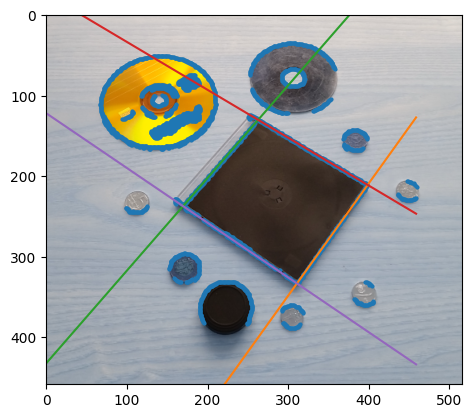

In [279]:
x=np.linspace(0,image.shape[0],image.shape[0])
plt.plot(edge_positions_cpy[:,0],edge_positions_cpy[:,1],'o',markersize=2)
for line in lines:
    plt.plot(x,line.a*x+line.b)
plt.imshow(image)
